<a href="https://colab.research.google.com/github/lululxvi/deepxde/blob/master/examples/Lorenz_inverse_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Install packages (run only once in the runtime)

In [ ]:
!pip install deepxde

Imports

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import io
import re

import matplotlib.pyplot as plt
import numpy as np
import requests

import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import odeint

Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



Train data generation

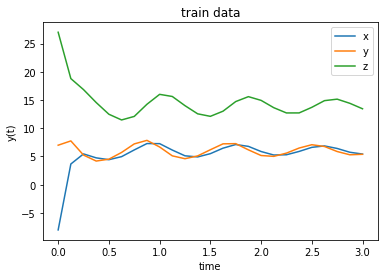

(25, 1)

In [2]:
# true values, see p. 15 in https://arxiv.org/abs/1907.04502
C1true = 10
C2true = 15
C3true = 8 / 3

# time points
maxtime = 3
time = np.linspace(0, maxtime, 25)

# function that returns dy/dt
def LorezODE(y, t):
    y1, y2, y3 = y
    dydt = [
        C1true * (y2 - y1),
        y1 * (C2true - y3) - y2,
        y1 * y2 - C3true * y3,
    ]
    return dydt


# initial condition
y0 = [-8, 7, 27]

# solve ODE
y = odeint(LorezODE, y0, time)

# plot results
plt.plot(time, y)
plt.legend(['x','y','z'])
plt.xlabel("time")
plt.ylabel("y(t)")
plt.title("train data")
plt.show()

time = time.reshape(-1, 1)
time.shape


Residual of DE (for inverse problem)

In [3]:
# parameters to be identified (for inverse problem)
C1 = tf.Variable(1.0)
C2 = tf.Variable(1.0)
C3 = tf.Variable(1.0)

# define system ODEs
def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (28 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]

def boundary(_, on_initial):
    return on_initial

Residual of DE (for forward problem)

In [ ]:
# for forward problem
C1 = C1true # 10
C2 = C2true # 15
C3 = C3true # 8/3


# define system ODEs
def Lorenz_system(x, y):
    """Lorenz system.
    dy1/dx = 10 * (y2 - y1)
    dy2/dx = y1 * (28 - y3) - y2
    dy3/dx = y1 * y2 - 8/3 * y3
    """
    y1, y2, y3 = y[:, 0:1], y[:, 1:2], y[:, 2:]
    dy1_x = dde.grad.jacobian(y, x, i=0)
    dy2_x = dde.grad.jacobian(y, x, i=1)
    dy3_x = dde.grad.jacobian(y, x, i=2)
    return [
        dy1_x - C1 * (y2 - y1),
        dy2_x - y1 * (C2 - y3) + y2,
        dy3_x - y1 * y2 + C3 * y3,
    ]

def boundary(_, on_initial):
    return on_initial

Define data and BCs

In [7]:
# define time domain
geom = dde.geometry.TimeDomain(0, 3)

# Initial conditions
ic1 = dde.IC(geom, lambda X: -8, boundary, component=0)
ic2 = dde.IC(geom, lambda X: 7, boundary, component=1)
ic3 = dde.IC(geom, lambda X: 27, boundary, component=2)

# Get the training data
observe_t, ob_y =(time, y)  
observe_y0 = dde.PointSetBC(observe_t, ob_y[:, 0:1], component=0)
observe_y1 = dde.PointSetBC(observe_t, ob_y[:, 1:2], component=1)
observe_y2 = dde.PointSetBC(observe_t, ob_y[:, 2:3], component=2)

# define data object
data = dde.data.PDE(
    geom,
    Lorenz_system,
    [ic1, ic2, ic3, observe_y0, observe_y1, observe_y2],
    num_domain=400,
    num_boundary=2,
    anchors=observe_t,
)

c:\users\hyemin\appdata\local\programs\python\python39\lib\site-packages\skopt\sampler\sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+402=402. 
  warnings.warn("The balance properties of Sobol' points require "


Train network (for inverse problem)

In [8]:
# define FNN architecture and compile
net = dde.maps.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

# callbacks for storing results (for inverse problem)
fnamevar = "variables.dat"
variable = dde.callbacks.VariableValue(
    [C1, C2, C3], 
    period=1,
    filename=fnamevar
)

losshistory, train_state = model.train(epochs=60000, callbacks=[variable])

Compiling model...
Building feed-forward neural network...
'build' took 0.046487 s



c:\users\hyemin\appdata\local\programs\python\python39\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:107: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
c:\users\hyemin\appdata\local\programs\python\python39\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.454462 s

Initializing variables...
Training model...

Step      Train loss                                                                                    Test loss                                                                                     Test metric
0         [1.40e-01, 9.84e-02, 5.04e-01, 6.40e+01, 4.90e+01, 7.29e+02, 3.77e+01, 3.58e+01, 2.12e+02]    [1.40e-01, 9.84e-02, 5.04e-01, 6.40e+01, 4.90e+01, 7.29e+02, 3.77e+01, 3.58e+01, 2.12e+02]    []  
1000      [7.04e+00, 2.91e+00, 3.16e+00, 2.80e+01, 6.18e-03, 8.35e-01, 3.55e+01, 7.56e+00, 1.02e+01]    [7.04e+00, 2.91e+00, 3.16e+00, 2.80e+01, 6.18e-03, 8.35e-01, 3.55e+01, 7.56e+00, 1.02e+01]    []  
2000      [9.34e+00, 1.93e+00, 1.12e+00, 1.49e+01, 2.21e-01, 1.01e+00, 3.57e+01, 1.47e+01, 3.63e+00]    [9.34e+00, 1.93e+00, 1.12e+00, 1.49e+01, 2.21e-01, 1.01e+00, 3.57e+01, 1.47e+01, 3.63e+00]    []  
3000      [8.63e+00, 1.96e+00, 7.14e-01, 1.07e+01, 2.49e-01, 9.12e-01, 3.57e+01, 1.86e+01, 1.72e+00]    [8.63

39000     [1.87e-03, 2.29e-03, 2.24e-03, 1.66e-06, 5.80e-08, 1.57e-07, 3.94e-03, 1.96e-03, 1.63e-03]    [1.87e-03, 2.29e-03, 2.24e-03, 1.66e-06, 5.80e-08, 1.57e-07, 3.94e-03, 1.96e-03, 1.63e-03]    []  
40000     [3.97e-02, 6.07e-03, 8.01e-03, 3.38e-06, 2.14e-05, 1.27e-06, 4.53e-03, 1.44e-03, 1.77e-03]    [3.97e-02, 6.07e-03, 8.01e-03, 3.38e-06, 2.14e-05, 1.27e-06, 4.53e-03, 1.44e-03, 1.77e-03]    []  
41000     [8.86e-03, 3.54e-03, 1.08e-02, 2.26e-05, 2.33e-06, 5.64e-06, 2.90e-03, 1.41e-03, 1.41e-03]    [8.86e-03, 3.54e-03, 1.08e-02, 2.26e-05, 2.33e-06, 5.64e-06, 2.90e-03, 1.41e-03, 1.41e-03]    []  
42000     [1.56e-03, 1.89e-03, 1.98e-03, 1.90e-06, 2.10e-07, 4.08e-07, 3.11e-03, 1.51e-03, 1.29e-03]    [1.56e-03, 1.89e-03, 1.98e-03, 1.90e-06, 2.10e-07, 4.08e-07, 3.11e-03, 1.51e-03, 1.29e-03]    []  
43000     [1.52e-03, 1.84e-03, 1.97e-03, 2.08e-06, 2.69e-07, 1.07e-06, 2.89e-03, 1.44e-03, 1.19e-03]    [1.52e-03, 1.84e-03, 1.97e-03, 2.08e-06, 2.69e-07, 1.07e-06, 2.89e-03, 1.44e-03, 1.1

Train network (for forward problem)

In [ ]:
# define FNN architecture and compile
net = dde.maps.FNN([1] + [40] * 3 + [3], "tanh", "Glorot uniform")
model = dde.Model(data, net)
model.compile("adam", lr=0.001)

losshistory, train_state = model.train(epochs=60000)

 Plot identified parameters (for inverse problem)

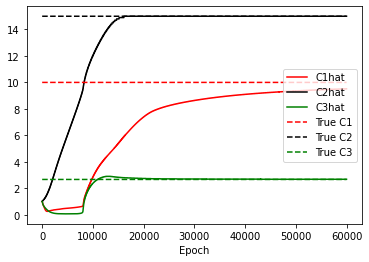

In [9]:
# reopen saved data using callbacks in fnamevar 
lines = open(fnamevar, "r").readlines()

# read output data in fnamevar (this line is a long story...)
Chat = np.array([np.fromstring(min(re.findall(re.escape('[')+"(.*?)"+re.escape(']'),line), key=len), sep=',') for line in lines])

l,c = Chat.shape

plt.plot(range(l),Chat[:,0],'r-')
plt.plot(range(l),Chat[:,1],'k-')
plt.plot(range(l),Chat[:,2],'g-')
plt.plot(range(l),np.ones(Chat[:,0].shape)*C1true,'r--')
plt.plot(range(l),np.ones(Chat[:,1].shape)*C2true,'k--')
plt.plot(range(l),np.ones(Chat[:,2].shape)*C3true,'g--')
plt.legend(['C1hat','C2hat','C3hat','True C1','True C2','True C3'],loc = "right")
plt.xlabel('Epoch')
plt.show()

Check how it was fitted to train data

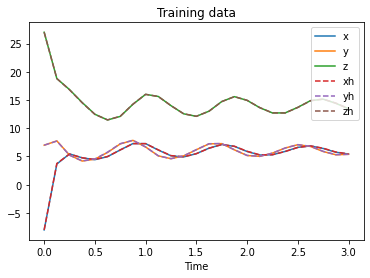

In [10]:
yhat = model.predict(observe_t)

plt.plot(observe_t, ob_y,'-',observe_t, yhat,'--')
plt.xlabel('Time')
plt.legend(['x','y','z','xh','yh','zh'])
plt.title('Training data')
plt.show()

Prediction for unknown t (same parameters, same initial condition, longer time)

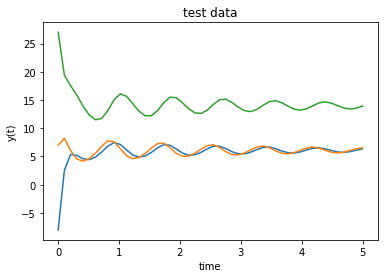

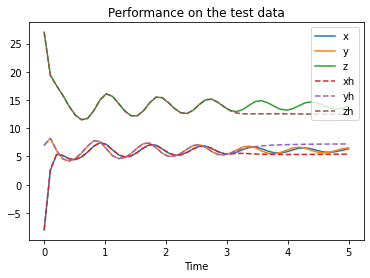

In [12]:
# true values, see p. 15 in https://arxiv.org/abs/1907.04502
C1true = 10
C2true = 15
C3true = 8 / 3

# time points
maxtime = 5
time_test = np.linspace(0, maxtime, 50)

# function that returns dy/dt
def LorezODE(y, t):
    y1, y2, y3 = y
    dydt = [
        C1true * (y2 - y1),
        y1 * (C2true - y3) - y2,
        y1 * y2 - C3true * y3,
    ]
    return dydt


# initial condition
y0 = [-8, 7, 27]

# solve ODE
y_test = odeint(LorezODE, y0, time_test)

# plot results
plt.plot(time_test, y_test)
plt.xlabel("time")
plt.ylabel("y(t)")
plt.title("test data")
plt.show()

time_test = time_test.reshape(-1, 1)
time_test.shape

yhat = model.predict(time_test)

plt.plot(time_test, y_test,'-',time_test, yhat,'--')
plt.xlabel('Time')
plt.legend(['x','y','z','xh','yh','zh'])
plt.title('Performance on the test data')
plt.show()